# WaveBot MASK Workshop

In [1]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt

import wecopttool as wot


## 1. Common
### Mesh

In [2]:
wb = wot.geom.WaveBot()
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)


### DOFs

In [3]:
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
fb.add_translation_dof(name="Surge")
ndof = fb.nb_dofs


### Hydrostatics

In [4]:
hydro_stiffness = wot.hydrostatics.stiffness_matrix(fb).values  # N/m
mass = wot.hydrostatics.inertia_matrix(fb).values  # kg


### Frequencies

In [5]:
f1 = 0.05  # Hz
nfreq = 50
freq = wot.frequency(f1, nfreq, False)  # Hz, # False -> no zero frequency


### BEM

In [6]:
bem_data = wot.run_bem(fb, freq)


The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.01e-01 > λ/8.
The resolution of the mesh 'WaveBot' of the body 'WaveBot_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

### PTO

In [7]:
## PTO impedance definition
omega = bem_data.omega.values  # rad/s
gear_ratio = 12.0  # rad/m
torque_constant = 6.7  # N*m/A
winding_resistance = 0.5  # Ω
winding_inductance = 0.0  # H
drivetrain_inertia = 2.0  # kg*m^2
drivetrain_friction = 1.0  # N*m*s/rad
drivetrain_stiffness = 0.0  # N*m/rad

drivetrain_impedance = (1j*omega*drivetrain_inertia +
                        drivetrain_friction +
                        1/(1j*omega)*drivetrain_stiffness)

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance

pto_impedance_00 = np.zeros(omega.shape)

pto_impedance = np.array([
    [pto_impedance_11, pto_impedance_00, pto_impedance_12, pto_impedance_00],
    [pto_impedance_00, pto_impedance_11, pto_impedance_00, pto_impedance_12],
    [pto_impedance_21, pto_impedance_00, pto_impedance_22, pto_impedance_00],
    [pto_impedance_00, pto_impedance_21, pto_impedance_00, pto_impedance_22],
])

# PTO
pto_name = ['PTO_Heave', 'PTO_Surge']
kinematics = np.eye(ndof)
loss = None


### Constraints

In [8]:
constraints = []


### Waves

In [9]:
regular = True

if regular:
    amplitude = 0.2
    wavefreq = 0.3
    waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude)
else:
    fp = 0.3
    Hm0 = 0.2
    omnidirectional_spectrum = wot.waves.omnidirectional_spectrum(
        f1=f1,
        nfreq=nfreq,
        spectrum_func=lambda f: wot.waves.jonswap_spectrum(freq=f, fp=fp, hs=Hm0, gamma=3.3),
        spectrum_name="JONSWAP",
    )
    waves = wot.waves.long_crested_wave(omnidirectional_spectrum, 0, seed=13)


### post-process

In [10]:
nsubstep_postprocess = 4


## 2. Solve symmetric PI

In [33]:
# PTO/controller
controller_symm = wot.pto.controller_pi
pto_symm = wot.pto.PTO(ndof, kinematics, controller_symm, pto_impedance, loss, pto_name)

# additional forces
f_add_symm = {'PTO': pto_symm.force_on_wec,}

# WEC object
wec_symm = wot.WEC.from_bem(bem_data,
                       inertia_matrix=mass,
                       hydrostatic_stiffness=hydro_stiffness,
                       constraints=constraints,
                       friction=None,
                       f_add=f_add_symm,
)

# objective function
nstate_opt_symm = wot.pto.nstate_pid(2, 2, False, True)
obj_fun_symm = pto_symm.average_power

# Solve
scale_x_wec_symm = 1e2
scale_x_opt_symm = 1e-1
scale_obj_symm = 1

options_symm = {'maxiter': 300}

results_symm = wec_symm.solve(
    waves,
    obj_fun_symm,
    nstate_opt_symm,
    scale_x_wec=scale_x_wec_symm,
    scale_x_opt=scale_x_opt_symm,
    scale_obj=scale_obj_symm,
    optim_options = options_symm,
)

print(f'Optimal average electrical power (symmetric): {results_symm.fun} W')

# Post-process
wec_fdom_symm, wec_tdom_symm = wec_symm.post_process(results_symm, waves, nsubstep_postprocess)
pto_fdom_symm, pto_tdom_symm = pto_symm.post_process(wec_symm, results_symm, waves, nsubstep_postprocess)

# - W


Iteration limit reached    (Exit mode 9)
            Current function value: -260.6164359864182
            Iterations: 300
            Function evaluations: 2286
            Gradient evaluations: 300
Optimal average electrical power (symmetric): -260.6164359864182 W


## 3. Solve asymmetric

In [13]:
# PTO/controller
def controller_asym(p,w,xw,xo,wa,ns):
    return wot.pto.controller_pi(p,w,xw,xo,wa,ns,symmetric=False)

pto_asym = wot.pto.PTO(ndof, kinematics, controller_asym, pto_impedance, loss, pto_name)

# additional forces
f_add_asym = {'PTO': pto_asym.force_on_wec,}

# WEC object
wec_asym = wot.WEC.from_bem(bem_data,
                       inertia_matrix=mass,
                       hydrostatic_stiffness=hydro_stiffness,
                       constraints=constraints,
                       friction=None,
                       f_add=f_add_asym,
)

# objective function
nstate_opt_asym = wot.pto.nstate_pid(2, 2, False, False)
obj_fun_asym = pto_asym.average_power

# Solve
scale_x_wec_asym = 1
scale_x_opt_asym = 1
scale_obj_asym = 1

options_asym = {'maxiter': 150}

results_asym = wec_asym.solve(
    waves,
    obj_fun_asym,
    nstate_opt_asym,
    scale_x_wec=scale_x_wec_asym,
    scale_x_opt=scale_x_opt_asym,
    scale_obj=scale_obj_asym,
    optim_options = options_asym,
)

print(f'Optimal average electrical power (asymmetrical): {results_asym.fun} W')

# Post-process
wec_fdom_asym, wec_tdom_asym = wec_asym.post_process(results_asym, waves, nsubstep_postprocess)
pto_fdom_asym, pto_tdom_asym = pto_asym.post_process(wec_asym, results_asym, waves, nsubstep_postprocess)

# -413 W


Optimization terminated successfully    (Exit mode 0)
            Current function value: -413.1053058735718
            Iterations: 82
            Function evaluations: 99
            Gradient evaluations: 82
Optimal average electrical power (asymmetrical): -413.1053058735718 W


## 4. Diagonal only PI

In [14]:
# PTO/controller
def controller_diag(pto, wec, x_wec, x_opt, waves=None, nsubsteps=1):
    return wot.pto.controller_pi(pto, wec, x_wec, x_opt, waves, nsubsteps, diagonal_only=True)

pto_diag = wot.pto.PTO(ndof, kinematics, controller_diag, pto_impedance, loss, pto_name)

# additional forces
f_add_diag = {'PTO': pto_diag.force_on_wec,}

# WEC object
wec_diag = wot.WEC.from_bem(bem_data,
                       inertia_matrix=mass,
                       hydrostatic_stiffness=hydro_stiffness,
                       constraints=constraints,
                       friction=None,
                       f_add=f_add_diag,
)

# objective function
nstate_opt_diag = wot.pto.nstate_pid(2, 2, True, False)
obj_fun_diag = pto_diag.average_power

# Solve
scale_x_wec_diag = 1
scale_x_opt_diag = 1
scale_obj_diag = 1

options_diag = {'maxiter': 100}

results_diag = wec_diag.solve(
    waves,
    obj_fun_diag,
    nstate_opt_diag,
    scale_x_wec=scale_x_wec_diag,
    scale_x_opt=scale_x_opt_diag,
    scale_obj=scale_obj_diag,
    optim_options = options_diag,
)

print(f'Optimal average electrical power (diagonal): {results_diag.fun} W')

# Post-process
wec_fdom_diag, wec_tdom_diag = wec_diag.post_process(results_diag, waves, nsubstep_postprocess)
pto_fdom_diag, pto_tdom_diag = pto_diag.post_process(wec_diag, results_diag, waves, nsubstep_postprocess)

# -346 W


Optimization terminated successfully    (Exit mode 0)
            Current function value: -346.56379997654943
            Iterations: 57
            Function evaluations: 59
            Gradient evaluations: 57
Optimal average electrical power (diagonal): -346.56379997654943 W


## 5.Plots

/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_68647/1231798571.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '-', color=cmap(icolor), label='_nolegend_', linestyle=istyle)
/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_68647/1231798571.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '-', color=cmap(icolor), label='_nolegend_', linestyle=istyle)


Text(0.5, 1.0, 'Heave')

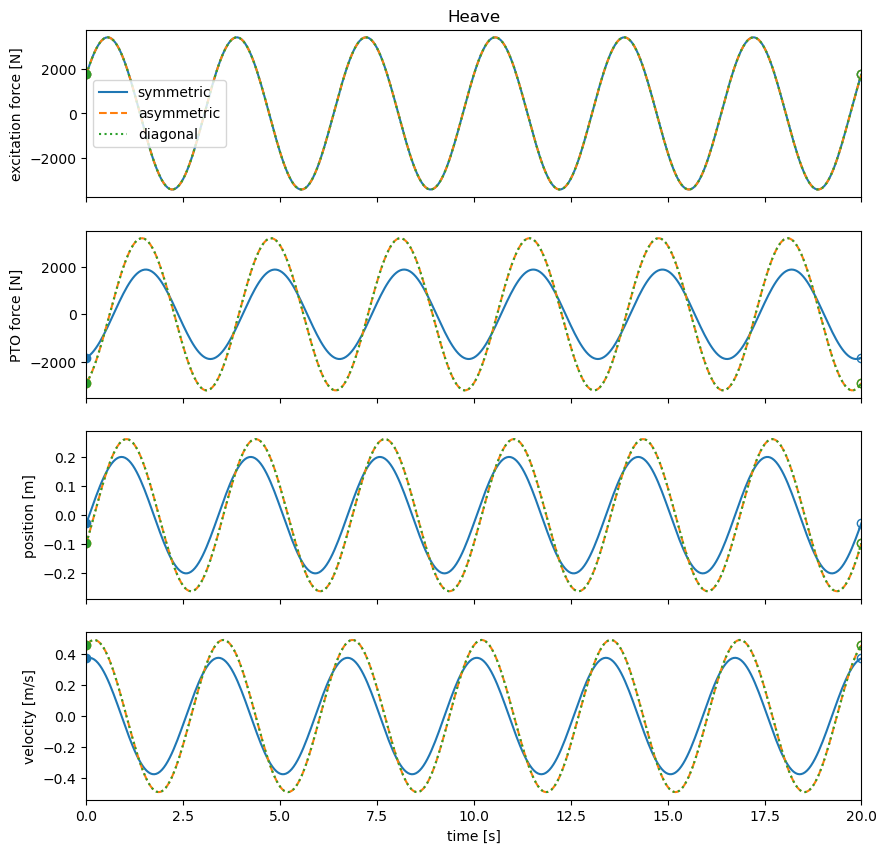

In [34]:
n = 4
fig, ax = plt.subplots(n,1, sharex=True, figsize=(10,10))
plt.xlim([0, wec_symm.tf])
cmap = plt.get_cmap("tab10")

def _plot(i, y, wec, icolor, istyle, ilabel=None):
    ilabel = '_nolegend' if ilabel is None else ilabel
    ax[i].plot(0, y[0], 'o', color=cmap(icolor), label='_nolegend_')
    ax[i].plot(wec.tf, y[0], 'o', color=cmap(icolor), markerfacecolor='none', label='_nolegend_')
    ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '-', color=cmap(icolor), label='_nolegend_', linestyle=istyle)
    y.plot(color=cmap(icolor), ax=ax[i], label=ilabel, linestyle=istyle); ax[i].set_xlabel(""); ax[i].set_title("")

icolor_symm, icolor_asym, icolor_diag = 0,1,2
istyle_symm, istyle_asym, istyle_diag = '-', '--', ':'


# excitation force
i = 0

y_symm = np.squeeze(
    wec_tdom_symm['force'].sel(type='Froude_Krylov', influenced_dof='DOF_0') +
    wec_tdom_symm['force'].sel(type='diffraction', influenced_dof='DOF_0')
)
y_asym = np.squeeze(
    wec_tdom_asym['force'].sel(type='Froude_Krylov', influenced_dof='DOF_0') +
    wec_tdom_asym['force'].sel(type='diffraction', influenced_dof='DOF_0')
)
y_diag = np.squeeze(
    wec_tdom_diag['force'].sel(type='Froude_Krylov', influenced_dof='DOF_0') +
    wec_tdom_diag['force'].sel(type='diffraction', influenced_dof='DOF_0')
)

_plot(i, y_symm, wec_symm, icolor=icolor_symm, istyle=istyle_symm, ilabel='symmetric')
_plot(i, y_asym, wec_asym, icolor=icolor_asym, ilabel='asymmetric', istyle=istyle_asym)
_plot(i, y_diag, wec_diag, icolor=icolor_diag, ilabel='diagonal', istyle=istyle_diag)

ax[i].set_ylabel('excitation force [N]')


# PTO force
i = 1

y_symm = np.squeeze(pto_tdom_symm['force'].sel(dof="PTO_Heave"))
y_asym = np.squeeze(pto_tdom_asym['force'].sel(dof="PTO_Heave"))
y_diag = np.squeeze(pto_tdom_diag['force'].sel(dof="PTO_Heave"))

_plot(i, y_symm, wec_symm, icolor=icolor_symm, istyle=istyle_symm)
_plot(i, y_asym, wec_asym, icolor=icolor_asym, istyle=istyle_asym)
_plot(i, y_diag, wec_diag, icolor=icolor_diag, istyle=istyle_diag)

ax[i].set_ylabel('PTO force [N]')

# position
i = 2

y_symm = np.squeeze(wec_tdom_symm['pos'].sel(influenced_dof='DOF_0'))
y_asym = np.squeeze(wec_tdom_asym['pos'].sel(influenced_dof='DOF_0'))
y_diag = np.squeeze(wec_tdom_diag['pos'].sel(influenced_dof='DOF_0'))

y_symm = y_symm - np.mean(y_symm)
y_asym = y_asym - np.mean(y_asym)
y_diag = y_diag - np.mean(y_diag)

_plot(i, y_symm, wec_symm, icolor=icolor_symm, istyle=istyle_symm)
_plot(i, y_asym, wec_asym, icolor=icolor_asym, istyle=istyle_asym)
_plot(i, y_diag, wec_diag, icolor=icolor_diag, istyle=istyle_diag)

ax[i].set_ylabel('position [m]')


# velocity
i = 3

y_symm = np.squeeze(wec_tdom_symm['vel'].sel(influenced_dof='DOF_0'))
y_asym = np.squeeze(wec_tdom_asym['vel'].sel(influenced_dof='DOF_0'))
y_diag = np.squeeze(wec_tdom_diag['vel'].sel(influenced_dof='DOF_0'))

_plot(i, y_symm, wec_symm, icolor=icolor_symm, istyle=istyle_symm)
_plot(i, y_asym, wec_asym, icolor=icolor_asym, istyle=istyle_asym)
_plot(i, y_diag, wec_diag, icolor=icolor_diag, istyle=istyle_diag)

ax[i].set_ylabel('velocity [m/s]')

#
plt.xlabel("time [s]")
ax[0].legend()
ax[0].set_title("Heave")


/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_68647/1231798571.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '-', color=cmap(icolor), label='_nolegend_', linestyle=istyle)
/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_68647/1231798571.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '-', color=cmap(icolor), label='_nolegend_', linestyle=istyle)


Text(0.5, 1.0, 'Surge')

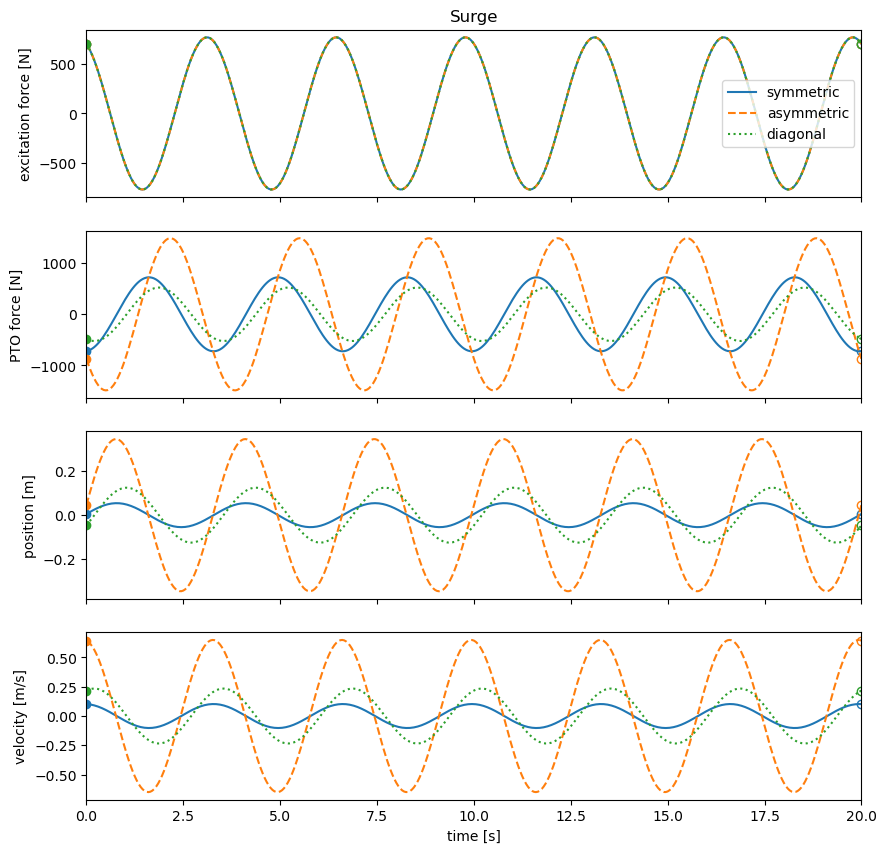

In [35]:
fig, ax = plt.subplots(n,1, sharex=True, figsize=(10,10))
plt.xlim([0, wec_symm.tf])

# excitation force
i = 0

y_symm = np.squeeze(
    wec_tdom_symm['force'].sel(type='Froude_Krylov', influenced_dof='DOF_1') +
    wec_tdom_symm['force'].sel(type='diffraction', influenced_dof='DOF_1')
)
y_asym = np.squeeze(
    wec_tdom_asym['force'].sel(type='Froude_Krylov', influenced_dof='DOF_1') +
    wec_tdom_asym['force'].sel(type='diffraction', influenced_dof='DOF_1')
)
y_diag = np.squeeze(
    wec_tdom_diag['force'].sel(type='Froude_Krylov', influenced_dof='DOF_1') +
    wec_tdom_diag['force'].sel(type='diffraction', influenced_dof='DOF_1')
)

_plot(i, y_symm, wec_symm, icolor=icolor_symm, istyle=istyle_symm, ilabel='symmetric')
_plot(i, y_asym, wec_asym, icolor=icolor_asym, ilabel='asymmetric', istyle=istyle_asym)
_plot(i, y_diag, wec_diag, icolor=icolor_diag, ilabel='diagonal', istyle=istyle_diag)

ax[i].set_ylabel('excitation force [N]')


# PTO force
i = 1

y_symm = np.squeeze(pto_tdom_symm['force'].sel(dof="PTO_Surge"))
y_asym = np.squeeze(pto_tdom_asym['force'].sel(dof="PTO_Surge"))
y_diag = np.squeeze(pto_tdom_diag['force'].sel(dof="PTO_Surge"))

_plot(i, y_symm, wec_symm, icolor=icolor_symm, istyle=istyle_symm)
_plot(i, y_asym, wec_asym, icolor=icolor_asym, istyle=istyle_asym)
_plot(i, y_diag, wec_diag, icolor=icolor_diag, istyle=istyle_diag)

ax[i].set_ylabel('PTO force [N]')

# position
i = 2

y_symm = np.squeeze(wec_tdom_symm['pos'].sel(influenced_dof='DOF_1'))
y_asym = np.squeeze(wec_tdom_asym['pos'].sel(influenced_dof='DOF_1'))
y_diag = np.squeeze(wec_tdom_diag['pos'].sel(influenced_dof='DOF_1'))

y_symm = y_symm - np.mean(y_symm)
y_asym = y_asym - np.mean(y_asym)
y_diag = y_diag - np.mean(y_diag)

_plot(i, y_symm, wec_symm, icolor=icolor_symm, istyle=istyle_symm)
_plot(i, y_asym, wec_asym, icolor=icolor_asym, istyle=istyle_asym)
_plot(i, y_diag, wec_diag, icolor=icolor_diag, istyle=istyle_diag)

ax[i].set_ylabel('position [m]')


# velocity
i = 3

y_symm = np.squeeze(wec_tdom_symm['vel'].sel(influenced_dof='DOF_1'))
y_asym = np.squeeze(wec_tdom_asym['vel'].sel(influenced_dof='DOF_1'))
y_diag = np.squeeze(wec_tdom_diag['vel'].sel(influenced_dof='DOF_1'))

_plot(i, y_symm, wec_symm, icolor=icolor_symm, istyle=istyle_symm)
_plot(i, y_asym, wec_asym, icolor=icolor_asym, istyle=istyle_asym)
_plot(i, y_diag, wec_diag, icolor=icolor_diag, istyle=istyle_diag)

ax[i].set_ylabel('velocity [m/s]')

#
plt.xlabel("time [s]")
ax[0].legend()
ax[0].set_title("Surge")


In [36]:
print("Heave gains (assymetric):\n")
print(np.reshape(results_asym.x[-nstate_opt_asym:-int(nstate_opt_asym/2)], [ndof, ndof]))

print("\nHeave gains (symetric):\n")
v = results_symm.x[-nstate_opt_asym:-int(nstate_opt_asym/2)]
k = np.diag(v[:ndof],0) + np.diag(v[ndof:ndof+ndof-1],1) + np.diag(v[ndof:ndof+ndof-1],-1)
print(k)

print("\nHeave gains (diagonal):\n")
print(np.diag(results_diag.x[-nstate_opt_diag:-int(nstate_opt_diag/2)]))


Heave gains (assymetric):

[[-4388.8055163  -1025.23039525]
 [ 1307.32657273 -3011.91610057]]

Heave gains (symetric):

[[ 1.62020458e-20 -3.35199745e+03]
 [-3.35199745e+03 -2.70080180e-20]]

Heave gains (diagonal):

[[-4407.40826666     0.        ]
 [    0.         -2229.31680788]]


In [37]:
print("Surge gains (assymetric):\n")
print(np.reshape(results_asym.x[-int(nstate_opt_asym/2):], [ndof, ndof]))

print("\nSurge gains (symetric):\n")
v = results_symm.x[-int(nstate_opt_asym/2):]
k = np.diag(v[:ndof],0) + np.diag(v[ndof:ndof+ndof-1],1) + np.diag(v[ndof:ndof+ndof-1],-1)
print(k)

print("\nSurge gains (diagonal):\n")
print(np.diag(results_diag.x[-int(nstate_opt_diag/2):]))


Surge gains (assymetric):

[[ 3736.4089523   3401.4677366 ]
 [-5393.45574195 -1142.45224016]]

Surge gains (symetric):

[[-5.07887939e+03 -7.72240452e-10]
 [-7.72240452e-10  2.11643759e+03]]

Surge gains (diagonal):

[[8.88442452e+03 0.00000000e+00]
 [0.00000000e+00 2.58529303e-18]]
